In [1]:
import pandas as pd
import pickle
import numpy as np
import re
from sklearn import linear_model


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from catboost import CatBoostRegressor


import joblib

import os
import warnings
warnings.filterwarnings('ignore') 

def get_score(y_test, y_pred):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    
    return(mae, mse, rmse, r2)

In [2]:
# 데이터 불러오기
#data = pd.read_csv('2008~2023_data.csv', engine='python')
data = pd.read_parquet('2008~2023_data.parquet')

In [3]:
data.head()

,Date,Line_num,Station,Station_num,Time,holiday,weekday,geton,getoff,get_all,...,Snow_amt_mean,Rainfall_amt_sum,Snow_amt_sum,Temp_max,Temp_min,Temp_diff,hour,year,month,day
0,2008-01-01,1,서울역(150),150,00:00,1,2,264.0,558.0,822.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
1,2008-01-01,1,시청(151),151,00:00,1,2,974.0,185.0,1159.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
2,2008-01-01,1,종각(152),152,00:00,1,2,1559.0,210.0,1769.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
3,2008-01-01,1,종로3가(153),153,00:00,1,2,1499.0,384.0,1883.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
4,2008-01-01,1,종로5가(154),154,00:00,1,2,140.0,42.0,182.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30239475 entries, 0 to 30239474
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   Line_num           int64  
 2   Station            object 
 3   Station_num        int64  
 4   Time               object 
 5   holiday            int64  
 6   weekday            int64  
 7   geton              float64
 8   getoff             float64
 9   get_all            float64
 10  Temp               float64
 11  Rainfall_amt       float64
 12  Wind_speed         float64
 13  Humidity           float64
 14  Snow_amt           float64
 15  Temp_mean          float64
 16  Rainfall_amt_mean  float64
 17  Wind_speed_mean    float64
 18  Humidity_mean      float64
 19  Snow_amt_mean      float64
 20  Rainfall_amt_sum   float64
 21  Snow_amt_sum       float64
 22  Temp_max           float64
 23  Temp_min           float64
 24  Temp_diff          float64
 25  hour            

In [5]:
data = data[(data['year'] >= 2018) & (data['year'] <= 2023)]

In [6]:
data['rainy'] = data['Rainfall_amt']>0.0
data['rainy'] = data['rainy'].astype(np.int32)

In [7]:
data['log_get_all'] = np.log1p(data['get_all'])

## 푸리에특징을 통한 시간연속성 표현(HOUR)
- 간단한 푸리에 변환을 활용하여, hour의 시간연속성을 데이터에 표현하였습니다.

In [8]:
def cyclical_encoding(x, max_val):
    sin_val = np.sin(2 * np.pi * x / max_val)
    cos_val = np.cos(2 * np.pi * x / max_val)
    return sin_val, cos_val

# hour 변수를 Cyclical Encoding으로 변환하여 대체하기
max_hour = 24
data['hour_sin'], data['hour_cos']= cyclical_encoding(data['hour'], max_hour)
data.drop('hour', axis=1, inplace=True)

# 결과 확인
data.head()

,Date,Line_num,Station,Station_num,Time,holiday,weekday,geton,getoff,get_all,...,Temp_max,Temp_min,Temp_diff,year,month,day,rainy,log_get_all,hour_sin,hour_cos
19688111,2018-01-01,1,서울역,150,00:00,1,1,96.0,147.0,243.0,...,3.7,-5.0,8.7,2018,1,1,0,5.497168,0.0,1.0
19688112,2018-01-01,1,시청,151,00:00,1,1,9.0,39.0,48.0,...,3.7,-5.0,8.7,2018,1,1,0,3.891820,0.0,1.0
19688113,2018-01-01,1,종각,152,00:00,1,1,28.0,33.0,61.0,...,3.7,-5.0,8.7,2018,1,1,0,4.127134,0.0,1.0
19688114,2018-01-01,1,종로3가,153,00:00,1,1,16.0,35.0,51.0,...,3.7,-5.0,8.7,2018,1,1,0,3.951244,0.0,1.0
19688115,2018-01-01,1,종로5가,154,00:00,1,1,8.0,28.0,36.0,...,3.7,-5.0,8.7,2018,1,1,0,3.610918,0.0,1.0


# 원핫인코딩 진행

In [9]:
# 역번호 원핫인코딩을 위한 데이터 프레임 만들기
sub_num_data = pd.get_dummies(data['Station_num'], prefix='sub_num', prefix_sep='_')

# 호선 원핫인코딩을 위한 데이터 프레임 만들기
line_num_data = pd.get_dummies(data['Line_num'], prefix='line_num', prefix_sep='_')

# 년도 원핫인코딩을 위한 데이터 프레임 만들기
# year_data = pd.get_dummies(data['year'], prefix='year', prefix_sep='_')

# 요일별 원핫인코딩을 위한 데이터 프레임 만들기
weekday_data = pd.get_dummies(data['weekday'], prefix='weekday', prefix_sep='_')

# 월별 원핫인코딩을 위한 데이터 프레임 만들기
month_data = pd.get_dummies(data['month'], prefix='month', prefix_sep='_')



In [10]:
selected_columns = ['log_get_all','holiday','rainy','hour_sin','hour_cos','year']
data = pd.concat([data[selected_columns],  sub_num_data, line_num_data,
                        weekday_data, month_data], axis=1)

In [11]:
del sub_num_data, line_num_data, weekday_data, month_data

In [12]:
dict_ = {}
for i in data.columns:
    dict_[i] = 0

print(dict_)


{'log_get_all': 0, 'holiday': 0, 'rainy': 0, 'hour_sin': 0, 'hour_cos': 0, 'year': 0, 'sub_num_150': 0, 'sub_num_151': 0, 'sub_num_152': 0, 'sub_num_153': 0, 'sub_num_154': 0, 'sub_num_155': 0, 'sub_num_156': 0, 'sub_num_157': 0, 'sub_num_158': 0, 'sub_num_159': 0, 'sub_num_201': 0, 'sub_num_202': 0, 'sub_num_203': 0, 'sub_num_204': 0, 'sub_num_205': 0, 'sub_num_206': 0, 'sub_num_207': 0, 'sub_num_208': 0, 'sub_num_209': 0, 'sub_num_210': 0, 'sub_num_211': 0, 'sub_num_212': 0, 'sub_num_213': 0, 'sub_num_214': 0, 'sub_num_215': 0, 'sub_num_216': 0, 'sub_num_217': 0, 'sub_num_218': 0, 'sub_num_219': 0, 'sub_num_220': 0, 'sub_num_221': 0, 'sub_num_222': 0, 'sub_num_223': 0, 'sub_num_224': 0, 'sub_num_225': 0, 'sub_num_226': 0, 'sub_num_227': 0, 'sub_num_228': 0, 'sub_num_229': 0, 'sub_num_230': 0, 'sub_num_231': 0, 'sub_num_232': 0, 'sub_num_233': 0, 'sub_num_234': 0, 'sub_num_235': 0, 'sub_num_236': 0, 'sub_num_237': 0, 'sub_num_238': 0, 'sub_num_239': 0, 'sub_num_240': 0, 'sub_num_241':

In [13]:
data.head()

,log_get_all,holiday,rainy,hour_sin,hour_cos,year,sub_num_150,sub_num_151,sub_num_152,sub_num_153,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
19688111,5.497168,1,0,0.0,1.0,2018,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19688112,3.891820,1,0,0.0,1.0,2018,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19688113,4.127134,1,0,0.0,1.0,2018,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19688114,3.951244,1,0,0.0,1.0,2018,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19688115,3.610918,1,0,0.0,1.0,2018,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# 독립변수, 종속변수 설정 하기 
X = data.drop(['log_get_all'],axis=1)
Y = data['log_get_all']


In [15]:
data.head()

,log_get_all,holiday,rainy,hour_sin,hour_cos,year,sub_num_150,sub_num_151,sub_num_152,sub_num_153,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
19688111,5.497168,1,0,0.0,1.0,2018,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19688112,3.891820,1,0,0.0,1.0,2018,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19688113,4.127134,1,0,0.0,1.0,2018,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
19688114,3.951244,1,0,0.0,1.0,2018,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
19688115,3.610918,1,0,0.0,1.0,2018,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# catboost 모델링

0:	learn: 1.1305858	total: 175ms	remaining: 2m 55s
1:	learn: 1.1116520	total: 281ms	remaining: 2m 20s
2:	learn: 1.0935109	total: 380ms	remaining: 2m 6s
3:	learn: 1.0761224	total: 483ms	remaining: 2m
4:	learn: 1.0595783	total: 588ms	remaining: 1m 56s
5:	learn: 1.0436818	total: 685ms	remaining: 1m 53s
6:	learn: 1.0282404	total: 783ms	remaining: 1m 51s
7:	learn: 1.0135819	total: 891ms	remaining: 1m 50s
8:	learn: 0.9996002	total: 990ms	remaining: 1m 49s
9:	learn: 0.9861405	total: 1.1s	remaining: 1m 48s
10:	learn: 0.9731653	total: 1.19s	remaining: 1m 47s
11:	learn: 0.9607277	total: 1.29s	remaining: 1m 46s
12:	learn: 0.9488612	total: 1.4s	remaining: 1m 46s
13:	learn: 0.9373399	total: 1.51s	remaining: 1m 46s
14:	learn: 0.9261977	total: 1.6s	remaining: 1m 45s
15:	learn: 0.9157045	total: 1.7s	remaining: 1m 44s
16:	learn: 0.9056325	total: 1.8s	remaining: 1m 43s
17:	learn: 0.8958714	total: 1.89s	remaining: 1m 43s
18:	learn: 0.8864438	total: 1.99s	remaining: 1m 42s
19:	learn: 0.8775004	total: 2.09

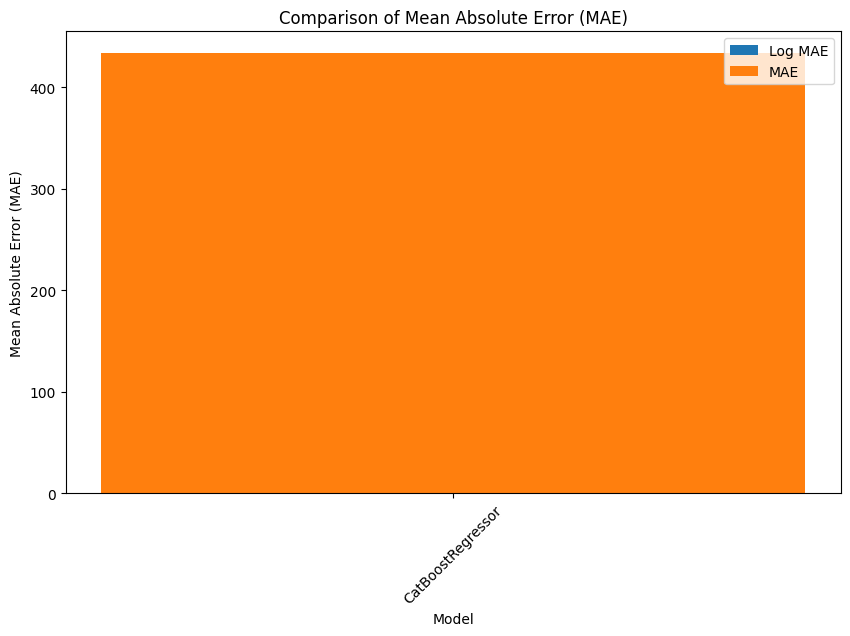

In [16]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Specify the start and end years for training and testing
train_start_year = 2018
train_end_year = 2021
test_start_year = 2022
test_end_year = 2023

# Filter the data based on the years
train_data = data[(data['year'] >= train_start_year) & (data['year'] <= train_end_year)]
test_data = data[(data['year'] >= test_start_year) & (data['year'] <= test_end_year)]

# Separate the features (X) and target variable (Y)
X_train = train_data.drop(['log_get_all'], axis=1)
Y_train = train_data['log_get_all']
X_test = test_data.drop(['log_get_all'], axis=1)
Y_test = test_data['log_get_all']

# Create a TimeSeriesSplit object for time series splitting
tscv = TimeSeriesSplit(n_splits=5)

# Variable initialization
log_mae_scores = []
mae_scores = []

# Create a list of models
models = [
    CatBoostRegressor(depth=12, iterations=1000, learning_rate=0.03, verbose=1, random_state=42),
]

# Outer loop: iterate over the time series segmentation
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]
    
    # Inner loop: estimate the model's performance through cross-validation
    for model in models:
        model.fit(X_train_fold, y_train_fold)  # Train the model
        
        scores = cross_val_score(model, X_train_fold, y_train_fold, scoring='neg_mean_absolute_error', cv=5)
        log_mean_score = -scores.mean()  # Negate the scores since cross_val_score returns negative values
        log_mae_scores.append(log_mean_score)
        
        # Evaluate the model on the validation set
        y_pred = np.expm1(model.predict(X_val_fold))
        mae = mean_absolute_error(np.expm1(y_val_fold), y_pred)
        mae_scores.append(mae)
        
        # Save the trained model using joblib
        joblib.dump(model, f'catboost_model_0623_ver1.pkl')

        print(f'{model.__class__.__name__} :')
        print('Log MAE:', log_mean_score)
        print('MAE:', mae)
        print('=' * 50)

# Visualize the results
model_names = [model.__class__.__name__ for model in models]

plt.figure(figsize=(10, 6))
plt.bar(model_names, log_mae_scores, label='Log MAE')
plt.bar(model_names, mae_scores, label='MAE')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of Mean Absolute Error (MAE)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


0:	learn: 1.1513349	total: 799ms	remaining: 13m 17s
1:	learn: 1.1322998	total: 1.55s	remaining: 12m 52s
2:	learn: 1.1138924	total: 2.31s	remaining: 12m 47s
3:	learn: 1.0960402	total: 3.12s	remaining: 12m 55s
4:	learn: 1.0792026	total: 3.89s	remaining: 12m 53s
5:	learn: 1.0632223	total: 4.78s	remaining: 13m 12s
6:	learn: 1.0477419	total: 5.56s	remaining: 13m 8s
7:	learn: 1.0328587	total: 6.42s	remaining: 13m 16s
8:	learn: 1.0187053	total: 7.25s	remaining: 13m 18s
9:	learn: 1.0050399	total: 8.14s	remaining: 13m 26s
10:	learn: 0.9918555	total: 8.98s	remaining: 13m 27s
11:	learn: 0.9793991	total: 9.87s	remaining: 13m 32s
12:	learn: 0.9674900	total: 10.8s	remaining: 13m 40s
13:	learn: 0.9561098	total: 11.7s	remaining: 13m 41s
14:	learn: 0.9449353	total: 12.5s	remaining: 13m 43s
15:	learn: 0.9342832	total: 13.3s	remaining: 13m 40s
16:	learn: 0.9237491	total: 14.1s	remaining: 13m 36s
17:	learn: 0.9140482	total: 15s	remaining: 13m 35s
18:	learn: 0.9042007	total: 15.7s	remaining: 13m 29s
19:	le

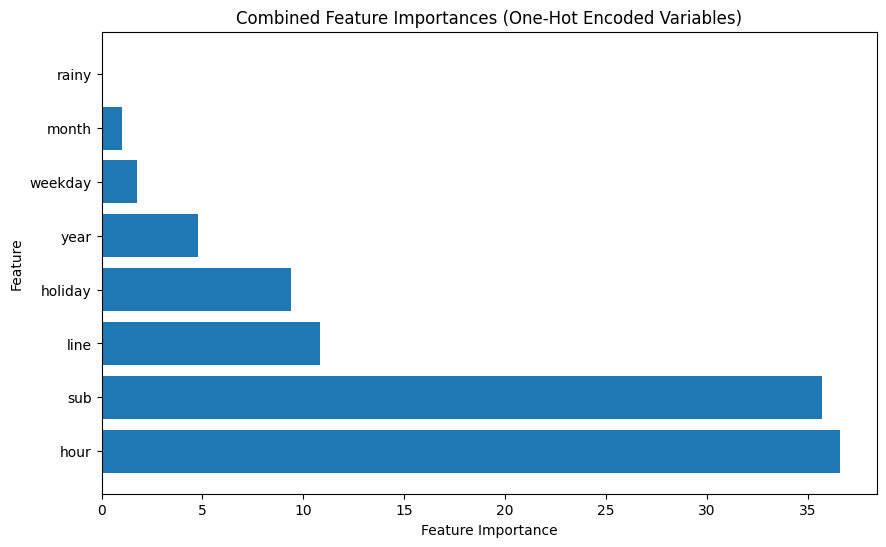

In [17]:
# Train the CatBoostRegressor model
catboost_model = CatBoostRegressor(depth=12, iterations=1000, learning_rate=0.03, verbose=1, random_state=42)
catboost_model.fit(X_train, Y_train)

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (One-Hot Encoded Variables)')
plt.show()